# Idefics2 finetuning of FrozenLake descriptions

We load the model with LoRA and quantization

In [1]:
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoProcessor, BitsAndBytesConfig, IdeficsForVisionText2Text, AutoConfig
from IPython.display import display
from datasets import load_dataset
from transformers import TrainingArguments, Trainer
import os

In [2]:
is_lora = True
checkpoint = "HuggingFaceM4/idefics-9b-instruct"

In [3]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype="bfloat16",
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_skip_modules=["lm_head", "embed_tokens"],
)

config = AutoConfig.from_pretrained(checkpoint)
model = IdeficsForVisionText2Text.from_pretrained(checkpoint, quantization_config=quantization_config, device_map='auto')
processor = AutoProcessor.from_pretrained(checkpoint)

processor.chat_template = AutoProcessor.from_pretrained("HuggingFaceM4/idefics2-8b").chat_template

#model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=gradient_ckpt, gradient_checkpointing_kwargs={'use_reentrant': False})

if is_lora:
    lora_config = LoraConfig(
        r=64,
        lora_alpha=16,
        target_modules=["q_proj", "k_proj", "v_proj"],
        # target_modules=r".*(perceiver_resampler|vision_model).*(q_proj|k_proj|v_proj)",
        lora_dropout=0.0,
        bias="none",
    )
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()

processor.tokenizer.mask_token = "[mask]"
processor.tokenizer.sep_token = "[sep]"
processor.tokenizer.cls_token = "[cls]"
# processor.tokenizer.cls_token_id = 25932 # this is the id for 'cls' (without angular brackets)
processor.tokenizer.cls_token_id = 3158  # this is the id for 'action'

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.
/home/davide/miniconda3/envs/idefics/lib/python3.10/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:360: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, qweight, scales, qzeros, g_idx, bits, maxq):
/home/davide/miniconda3/envs/idefics/lib/python3.10/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:368: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/home/davide/miniconda3/envs/idefics/lib/python3.10/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:399: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args...

trainable params: 79,003,648 || all params: 9,008,691,472 || trainable%: 0.8769714030672712


We load the dataset from the hub.

In [4]:
dataset_str = 'dawoz/frozenlake_prompts_dataset'

# dataset = load_from_disk(dataset_str)
dataset = load_dataset(dataset_str)

train_dataset = dataset['train']
eval_dataset = dataset['test']

Let's look at one example.



{'id': None,
 'task': 'describe_tile',
 'env_seed': None,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=64x64>,
 'instruction': 'Describe the tile you see in the image',
 'answer': 'The picture shows an ice cell'}

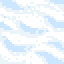

In [5]:
display(train_dataset[0])

display(train_dataset[0]["image"])

We define the data collator to construct the example with chat templates

In [6]:
class DescriptionTaskCollator:
    def __init__(self, processor, resize_to=None):
        self.processor = processor
        self.resize_to = resize_to
        self.image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")
        ]

    def __call__(self, examples):
        prompts = []
        for example in examples:
            image = example["image"]
            
            # resize image
            if self.resize_to is not None:
                image = image.resize(self.resize_to)
            
            instruction = example["instruction"]
            # answer = random.choice(example["answers"])  #todo implement multiple answers
            answer = example["answer"]
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text", "text": instruction}
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": answer}
                    ]
                }
            ]
            text = processor.apply_chat_template(messages, add_generation_prompt=False)
            prompt = text.split('<image>')
            prompt = [prompt[0], '\n', image, '\n', prompt[1]]
            prompts.append(prompt)

        batch = processor(prompts, return_tensors="pt", padding=True)

        labels = batch["input_ids"].clone()
        labels[labels == processor.tokenizer.pad_token_id] = -100
        # labels[labels == self.image_token_id] = -100  # da' errore su GPU ma non su colab
        batch["labels"] = labels

        return batch


data_collator = DescriptionTaskCollator(processor)


We define the training arguments.

In [7]:
os.environ["WANDB_PROJECT"] = "FrozenLake-VLM-fine-tuning"

training_args = TrainingArguments(
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    optim='adamw_bnb_8bit',
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=25,
    output_dir="outputs",
    run_name="IDEFICS-frozenlake",
    save_strategy="steps",
    save_steps=250,
    save_total_limit=1,
    eval_strategy="steps",
    eval_steps=250,
    fp16=True,
    push_to_hub=True,
    hub_model_id="IDEFICS-frozenlake",
    remove_unused_columns=False,
    report_to="wandb",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset, # You can also evaluate (loss) on the eval set, note that it will incur some additional GPU memory
)


/home/davide/miniconda3/envs/idefics/lib/python3.10/site-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


## Training and pushing to the hub

In [8]:
torch.cuda.empty_cache()
trainer.train()

[2024-08-01 09:23:21,346] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/davide/miniconda3/envs/idefics/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  NVIDIA Inference is only supported on Ampere and newer architectures
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.4
 [WARNING]  using untested triton version (3.0.0), only 1.0.0 is known to be compatible


/home/davide/miniconda3/envs/idefics/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:49: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, weight, bias=None):
/home/davide/miniconda3/envs/idefics/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:67: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dawoz. Use `wandb login --relogin` to force relogin


/home/davide/miniconda3/envs/idefics/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/davide/miniconda3/envs/idefics/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/davide/miniconda3/envs/idefics/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.

Step,Training Loss,Validation Loss


TrainOutput(global_step=144, training_loss=1.0099137905571196, metrics={'train_runtime': 1797.6264, 'train_samples_per_second': 2.567, 'train_steps_per_second': 0.08, 'total_flos': 5.345137051476826e+16, 'train_loss': 1.0099137905571196, 'epoch': 1.9965337954939342})

We push to the fine-tuned checkpoint to the hub!

In [9]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/dawoz/IDEFICS-frozenlake/commit/f30a401ab03ded28554b2548f32c497672644340', commit_message='End of training', commit_description='', oid='f30a401ab03ded28554b2548f32c497672644340', pr_url=None, pr_revision=None, pr_num=None)